In [6]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:43200")
# client

In [2]:
!pip install pyxpcm

  Using cached pyxpcm-0.4.1-py3-none-any.whl (51 kB)
  Using cached numpydoc-1.5.0-py3-none-any.whl (52 kB)
  Using cached sphinx-6.1.3-py3-none-any.whl (3.0 MB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
  Using cached alabaster-0.7.13-py3-none-any.whl (13 kB)
  Using cached sphinxcontrib_applehelp-1.0.4-py3-none-any.whl (120 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
  Using cached sphinxcontrib_htmlhelp-2.0.1-py3-none-any.whl (99 kB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
  Using cached docutils-0.19-py3-none-any.whl (570 kB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
  Using cached sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
  Using cached Pygments-2.14.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.12.0
    Uninstalling Pygments

In [3]:
from pyxpcm.models import pcm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyxpcm
import os
import tarfile
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
#Check whether the data already exist, if not, it will be downloaded and unziped
path='scienceweb.whoi.edu/itp/data/mark.tar.Z'
os.chdir('/home/jovyan') 

if not os.path.isfile(path):    
    print('Data file Not found, will be downloaded: ') 
    !wget -r --no-parent -A '*final.tar.Z' https://scienceweb.whoi.edu/itp/data/
    os.chdir('scienceweb.whoi.edu/itp/data') 
    !cat *.Z | tar -xvzf - -i
    tar = tarfile.open(path, "w:gz")
    tar.close()
       
os.chdir('/home/jovyan') 
        

Total  10911  profiles qualified
Total  10770  profiles dropped


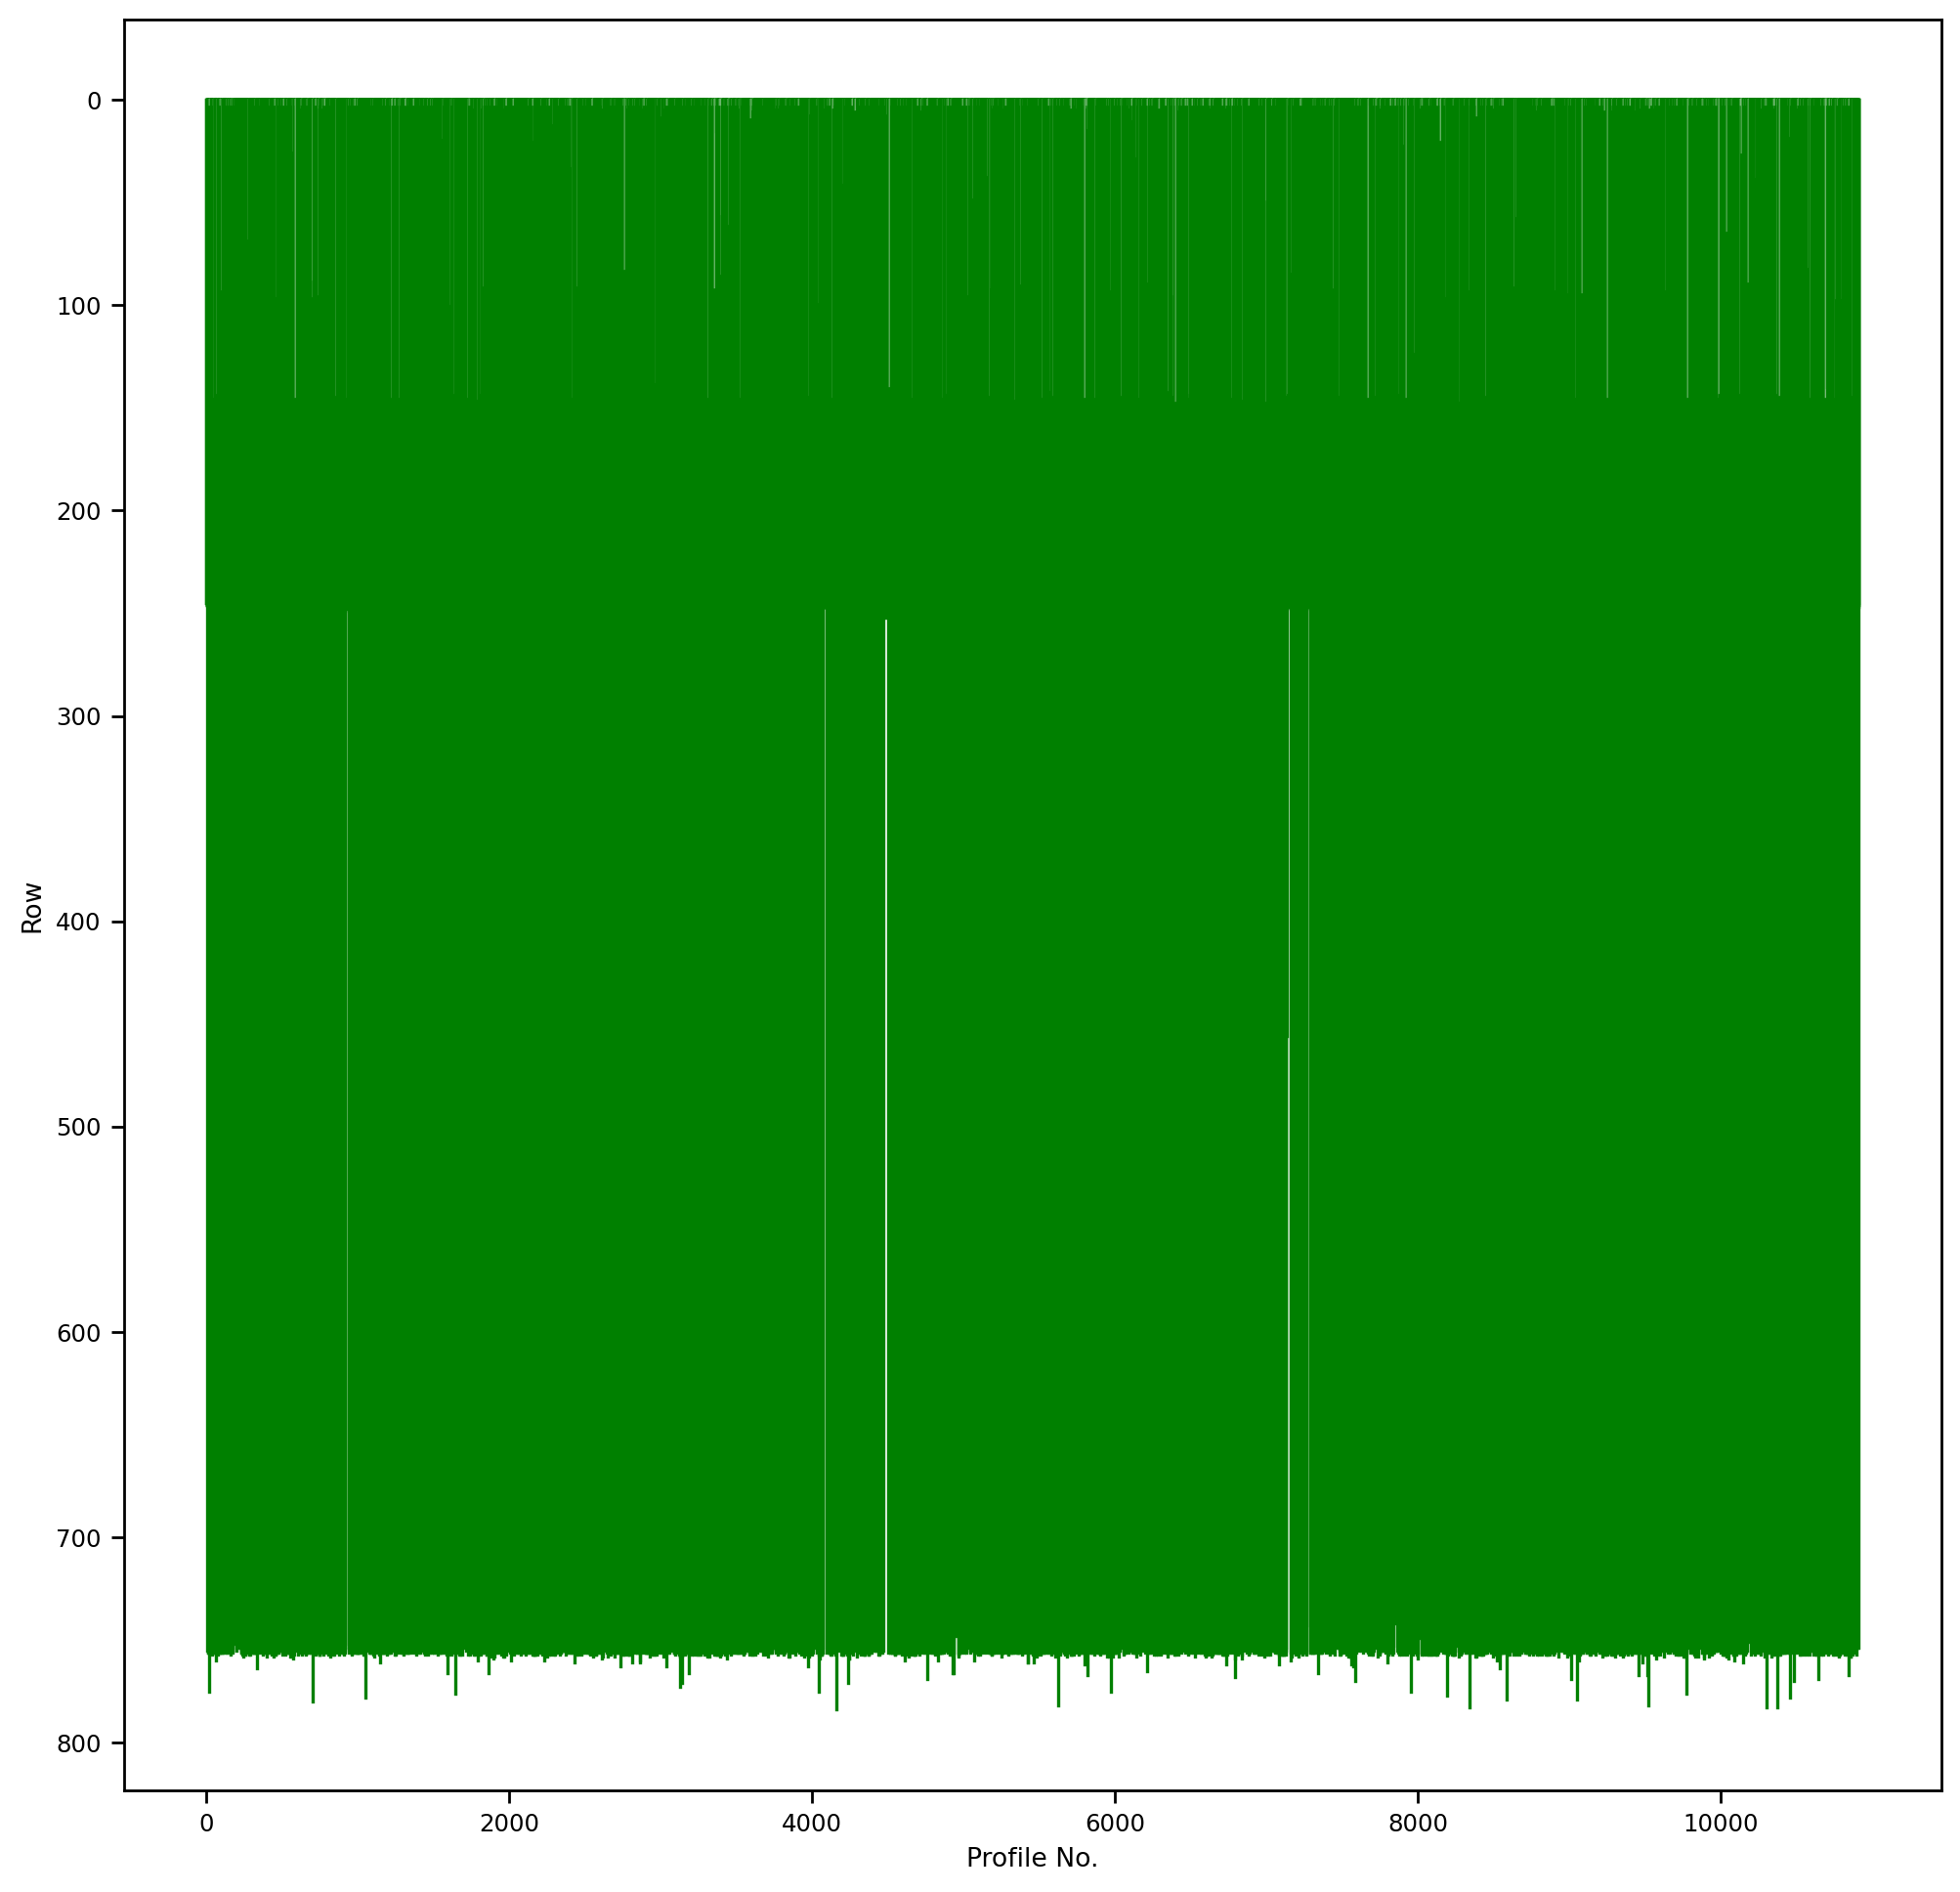

In [24]:
# the data filter
import glob
files = glob.glob('scienceweb.whoi.edu/itp/data/*.dat')
len(files)

pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)

plt.figure(figsize=(12, 12),dpi=200)

ds_all=[]
counter=0
drop_counter=0
for file in files:
    infile=open(file)
    metadata_names=infile.readline()
    metadata_vals=infile.readline().split()
    infile.close()
    if metadata_vals[-1].isnumeric(): 
        if int(metadata_vals[-1])>1:
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try: 
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                continue
                #print('wrong title, dropping'+metadata_names.split(':')[0])
                
            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                         'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                          'lon':float(metadata_vals[2]),
                          'lat':float(metadata_vals[3])}
                         )
            ds=ds.drop_duplicates('pressure',keep='last') 
            if 'dissolved_oxygen' in ds:
                ds=ds.drop('dissolved_oxygen')
            if ds.pressure.size>1:    #ds['pressure'][-1].values>pend:
                # tem_nan_check = ds['temperature'].isnull()
                # sa_nan_check=ds['salinity'].isnull()
                # if tem_nan_check.any() or sa_nan_check.any():
                #     continue
                # else:                        
                    plt.plot([counter,counter],[0,len(ds['temperature'])],c='g')
                    if ds.pressure.size<len(plevels):
                        plt.plot([counter,counter],[0,len(ds['temperature'])],c='w',linewidth=1.2)
                    ds_all.append(ds.interp({'pressure':plevels},assume_sorted=True)) # interpolate the pressure levels
                    counter=counter+1
            else:
                # print('Only 1 pressure level, dropping: '+metadata_names.split(':')[0])
                drop_counter=drop_counter+1
        else:
            # print('Only 1 measurement, dropping: '+metadata_names.split(':')[0])
            drop_counter=drop_counter+1
    else:
        # print('Wrong data fomart, dropping: '+metadata_names.split(':')[0])
        drop_counter=drop_counter+1

    # if counter==100:
    #     break

plt.gca().invert_yaxis()
plt.ylabel('Row')
plt.xlabel('Profile No.')

ds_all=xr.concat(ds_all,'nprof')
ds_all.pressure.attrs['units']='dbar'
ds_all.temperature.attrs['units']='C'
print('Total ',counter,' profiles qualified')
print('Total ',drop_counter,' profiles dropped')


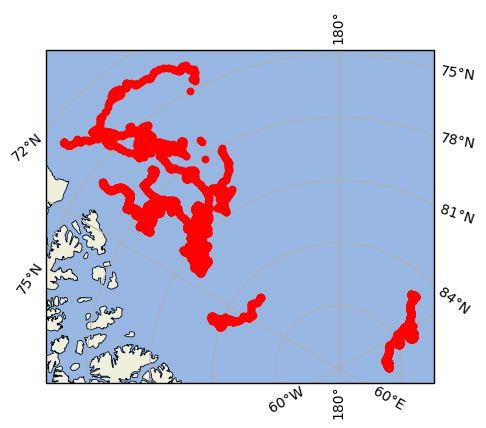

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100, subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_latitude=90)})

ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))

# add gridlines and set latitude labels
gl = ax.gridlines(draw_labels=True)
gl.left_labels = True
gl.bottom_labels = True


ax.scatter(ds_all['lon'].values,ds_all['lat'].values,c='r',transform=ccrs.PlateCarree(),zorder=4)
plt.show()

In [25]:
ds_all['pressure']=-ds_all['pressure']
pstart=-10.
pend=-500.
ds_cleaned=ds_all.sel(pressure=slice(pstart,pend)).dropna('nprof')
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 2614, pressure: 99)
Coordinates:
    profiler     (nprof) int64 105 108 10 104 103 107 ... 103 105 104 108 108
    date         (nprof) datetime64[ns] 2019-04-09T00:02:26.016000 ... 2018-0...
    lon          (nprof) float64 -129.8 -141.6 -112.0 ... -125.4 -140.5 -143.7
    lat          (nprof) float64 81.33 78.27 83.43 81.37 ... 81.63 75.71 76.79
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.665 -1.665 ... 0.7964 0.7895
    salinity     (nprof, pressure) float64 30.44 30.44 30.44 ... 34.83 34.83

In [26]:
ds_cleaned['temperature'].isel(nprof=10)

<xarray.DataArray 'temperature' (pressure: 99)>
array([-1.6081    , -1.6077    , -1.6076    , -1.51489091, -1.1549    ,
       -1.1592    , -1.1883    , -1.25443636, -1.4815    , -1.5       ,
       -1.55012727, -1.57682727, -1.56025455, -1.52675455, -1.4891    ,
       -1.4695    , -1.4638    , -1.38949091, -1.41568182, -1.46935455,
       -1.51139091, -1.5265    , -1.54318182, -1.55774545, -1.5655    ,
       -1.56698182, -1.54997273, -1.4656    , -1.3929    , -1.34501818,
       -1.28973636, -1.2068    , -1.1338    , -1.07147273, -1.012     ,
       -0.9235    , -0.8501    , -0.73881818, -0.6285    , -0.5465    ,
       -0.4698    , -0.404     , -0.3241    , -0.26646364, -0.18728182,
       -0.0677    , -0.0322    ,  0.03161   ,  0.10208182,  0.1696    ,
        0.2224    ,  0.22532727,  0.30627   ,  0.3798    ,  0.4104    ,
        0.4488    ,  0.49927273,  0.5295    ,  0.57973636,  0.6342    ,
        0.6351    ,  0.64307273,  0.6627    ,  0.6815    ,  0.7121    ,
        0.71229   ,  0.7109    ,  0.71036   ,  0.7063    ,  0.71322   ,
        0.7407    ,  0.77329   ,  0.7915    ,  0.82167   ,  0.8223    ,
        0.82260909,  0.8233    ,  0.8235    ,  0.8222    ,  0.8147    ,
        0.8158    ,  0.81592   ,  0.8069    ,  0.79836   ,  0.7851    ,
        0.77481818,  0.77155455,  0.7714    ,  0.78468   ,  0.7888    ,
        0.792     ,  0.78571   ,  0.7865    ,  0.775     ,  0.7602    ,
        0.7483    ,  0.7346    ,  0.72427273,  0.70944   ])
Coordinates:
    profiler  int64 108
    date      datetime64[ns] 2017-09-27T00:02:02.688000
    lon       float64 -135.9
    lat       float64 80.76
  * pressure  (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Attributes:
    units:    C

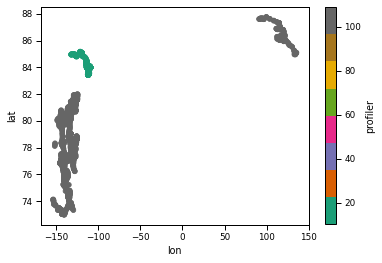

In [10]:
ds_cleaned.plot.scatter('lon','lat',hue='profiler',cmap='Dark2')

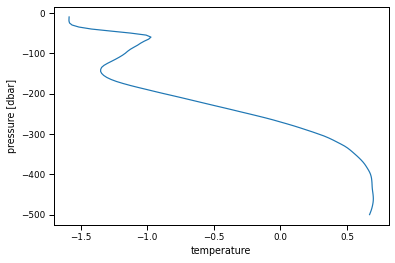

In [11]:
ds_cleaned['temperature'].mean('nprof').plot(y='pressure',yincrease=True)

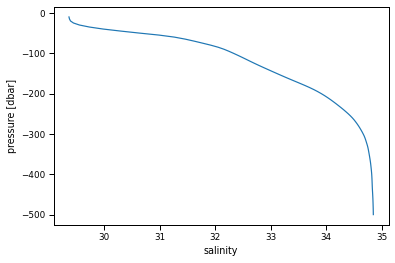

In [12]:
ds_cleaned['salinity'].mean('nprof').plot(y='pressure',yincrease=True)

In [13]:
z = np.arange(pstart,pend,-10.)
pcm_features = {'temperature': z, 'salinity':z}

In [14]:
m = pcm(K=3, features=pcm_features,maxvar=3)
m

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

In [15]:
features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}

In [16]:
m.fit(ds_cleaned,features=features_in_ds,dim='pressure')

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 1.033440

In [17]:
ds_cleaned=m.predict(ds_cleaned,features=features_in_ds,dim='pressure',inplace=True)

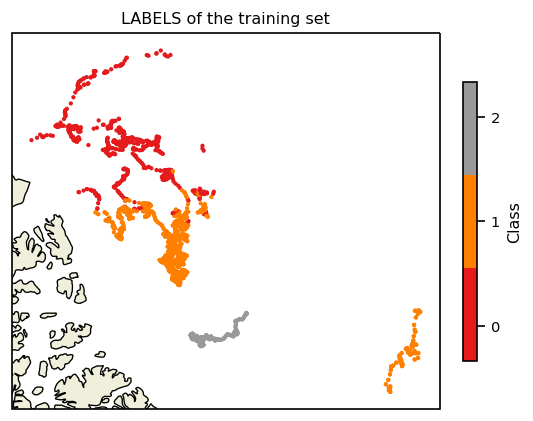

In [18]:
proj = ccrs.NorthPolarStereo()
subplot_kw={'projection': proj, 
            #'extent':([-180,180,60,90],ccrs.PlateCarree())
           }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds_cleaned['lon'], ds_cleaned['lat'], s=3, c=ds_cleaned['PCM_LABELS'], cmap=kmap, transform=ccrs.PlateCarree(), vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

#gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

In [19]:
for vname in ['temperature', 'salinity']:
    ds_cleaned = ds_cleaned.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)    
ds_cleaned

<xarray.Dataset>
Dimensions:                  (pcm_class_temperature_Q: 3, nprof: 2614,
                              pressure: 99, quantile: 3)
Coordinates:
  * pcm_class_temperature_Q  (pcm_class_temperature_Q) int64 0 1 2
  * nprof                    (nprof) int64 0 1 2 3 4 ... 2610 2611 2612 2613
    profiler                 (nprof) int64 105 108 10 104 ... 105 104 108 108
    date                     (nprof) datetime64[ns] 2019-04-09T00:02:26.01600...
    lon                      (nprof) float64 -129.8 -141.6 ... -140.5 -143.7
    lat                      (nprof) float64 81.33 78.27 83.43 ... 75.71 76.79
  * pressure                 (pressure) float64 -10.0 -15.0 ... -495.0 -500.0
  * quantile                 (quantile) float64 0.05 0.5 0.95
Data variables:
    temperature              (nprof, pressure) float64 -1.665 -1.665 ... 0.7895
    salinity                 (nprof, pressure) float64 30.44 30.44 ... 34.83
    PCM_LABELS               (nprof) int64 1 0 2 1 0 0 1 2 0 ... 1 1 1 1 1 1 0 0
    temperature_Q            (pcm_class_temperature_Q, quantile, pressure) float64 ...
    salinity_Q               (pcm_class_temperature_Q, quantile, pressure) float64 ...

In [20]:
fig, ax = m.plot.quantile(ds_cleaned['salinity_Q'], maxcols=4, figsize=(10, 8), sharey=True)

ValueError: Can't distinguish the class dimension from the others

In [22]:
ds_group = ds_cleaned.groupby('PCM_LABELS')

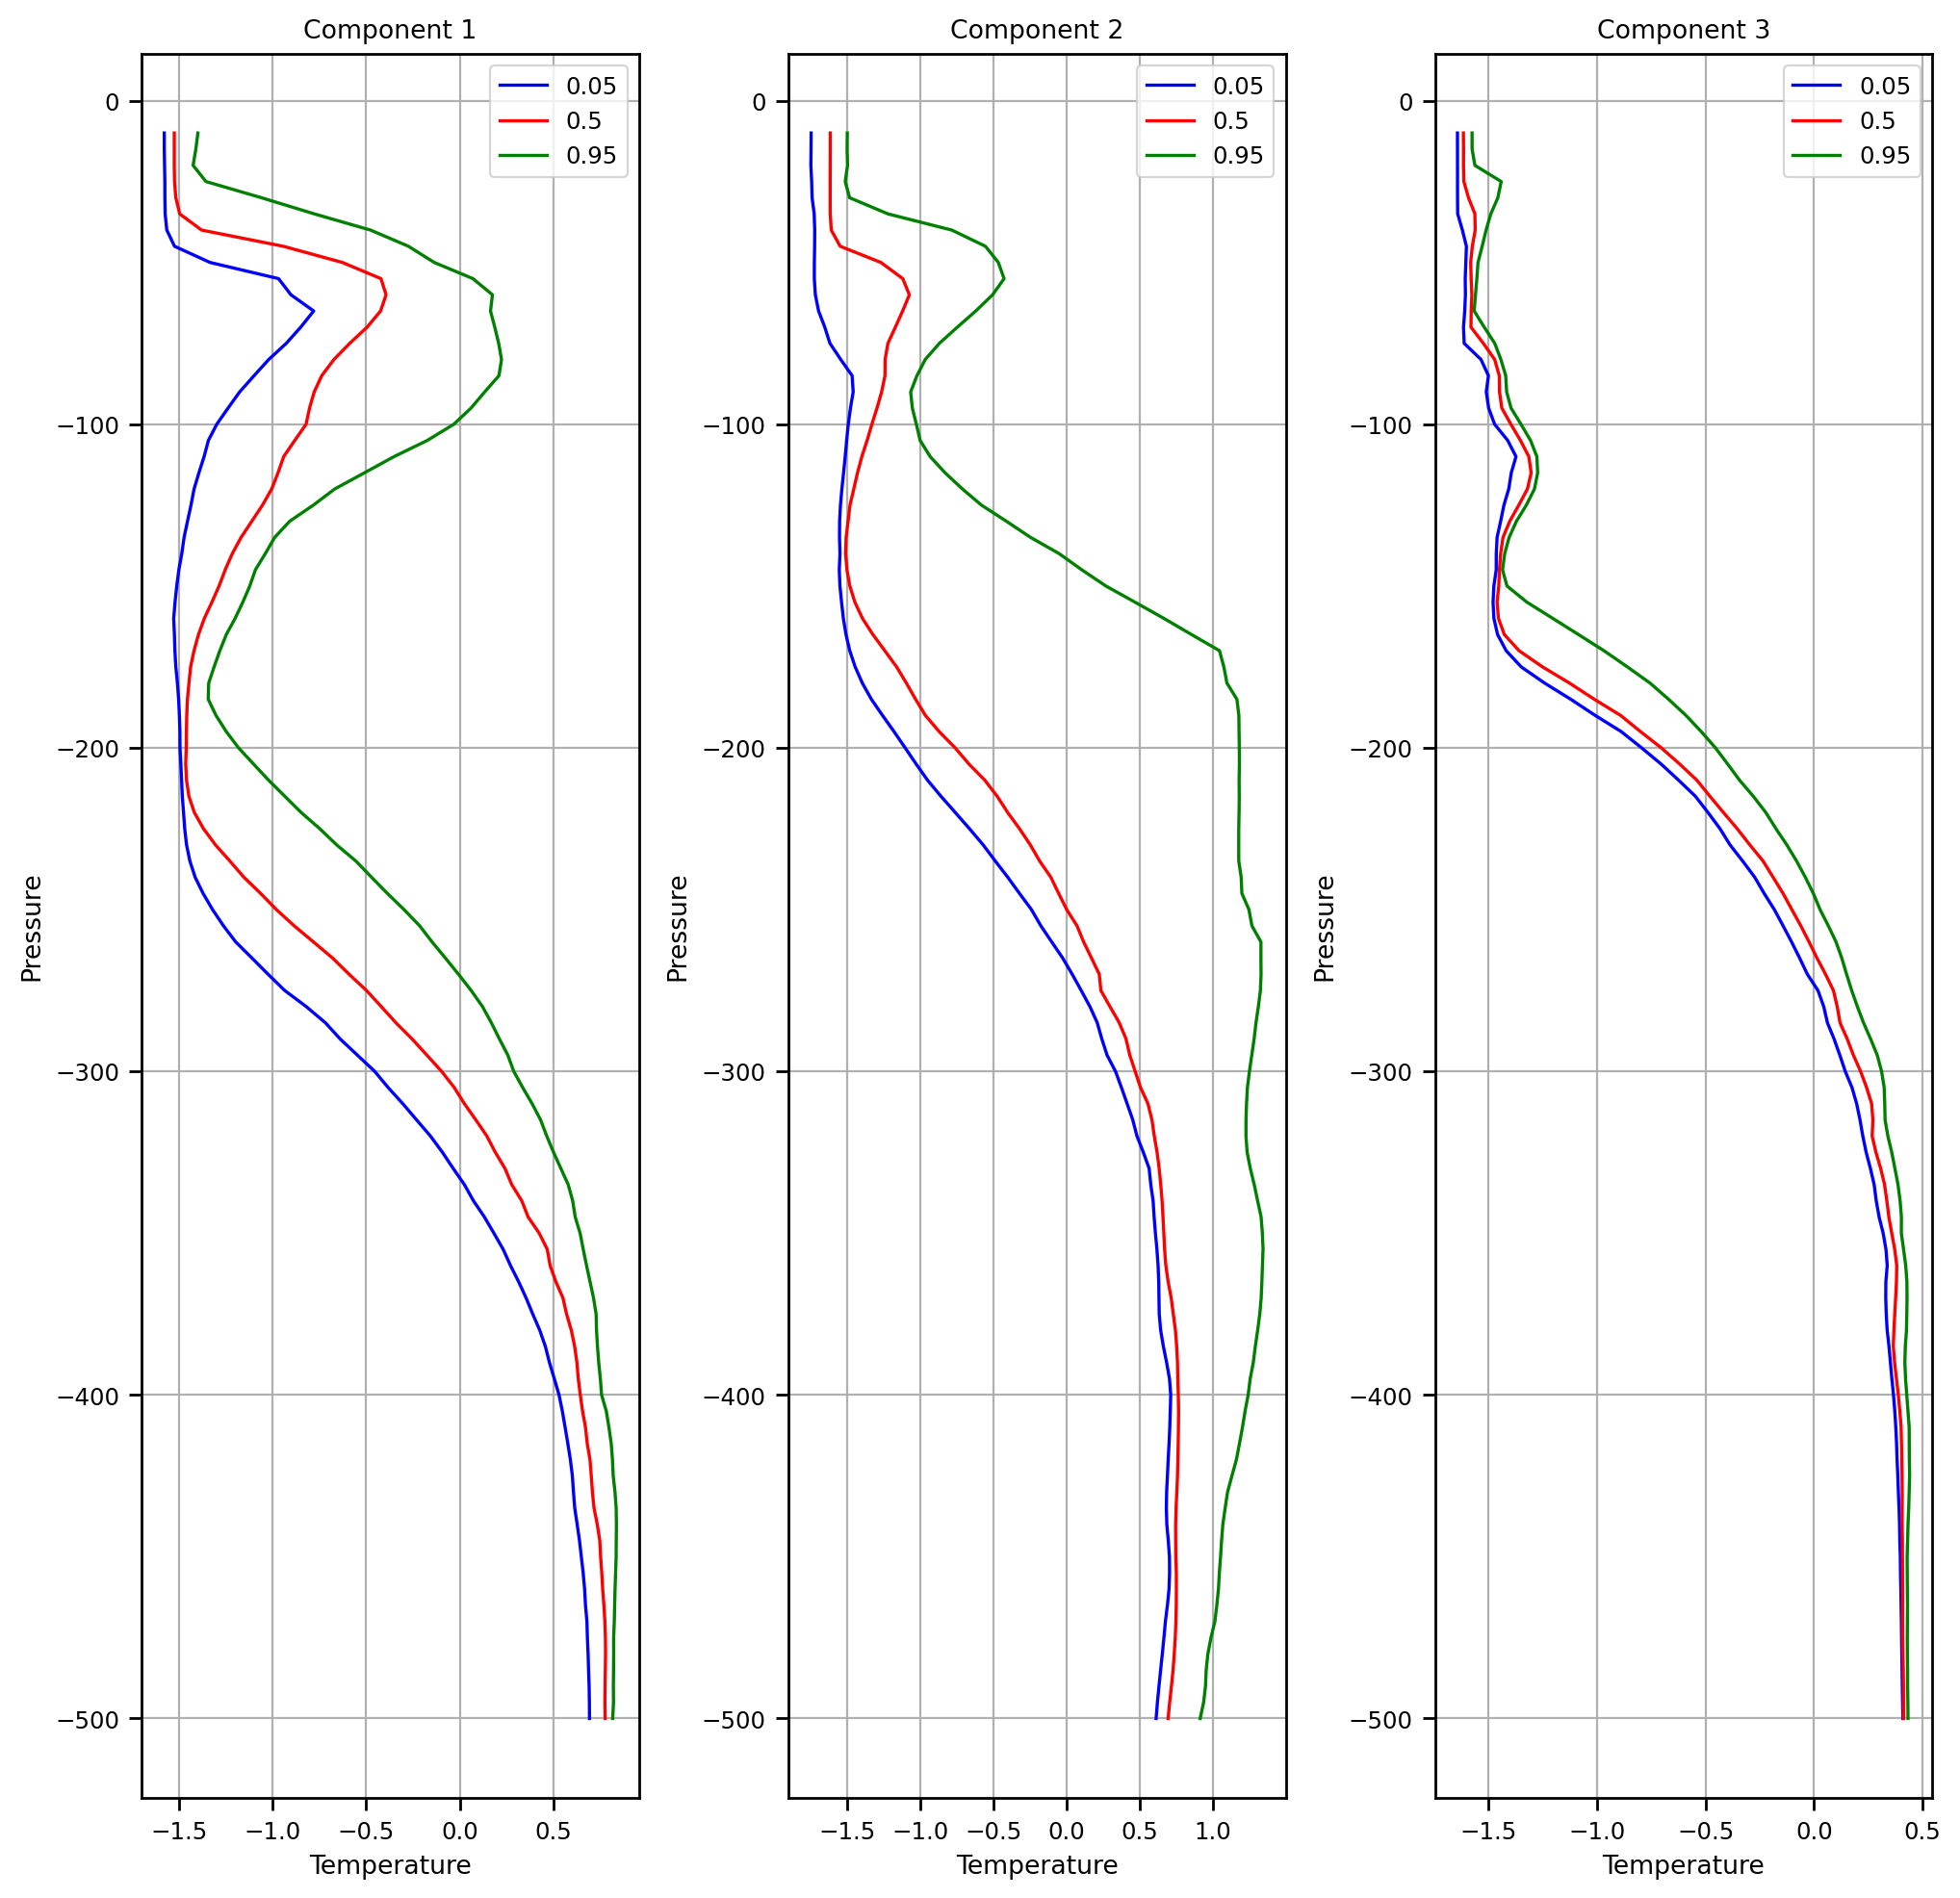

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12),dpi=200)

for i in range(3):
    qua5=ds_group[0]['temperature_Q'][i][0].values
    qua50=ds_group[0]['temperature_Q'][i][1].values
    qua95=ds_group[0]['temperature_Q'][i][2].values
    ax=axs[i]
    ax.plot(qua5,ds_group[0]['pressure'].values,c='b',label=0.05)
    ax.plot(qua50,ds_group[0]['pressure'].values,c='r',label=0.50)
    ax.plot(qua95,ds_group[0]['pressure'].values,c='g',label=0.95)
    ax.grid(True)
    ax.legend()
    ax.set_title(f'Component {i+1}')
    ax.set_ylabel('Pressure')
    ax.set_xlabel('Temperature')

plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.show()

    

In [369]:
np.shape(ds_group[0]['pressure'].values)

(99,)

In [371]:
np.shape(ds_group[i]['temperature_Q'][0].values)

(3, 99)

In [405]:
ds_group[0]

<xarray.Dataset>
Dimensions:                  (pcm_class_temperature_Q: 3, nprof: 112,
                              pressure: 99, quantile: 3)
Coordinates:
  * pcm_class_temperature_Q  (pcm_class_temperature_Q) int64 0 1 2
  * nprof                    (nprof) int64 20 49 74 111 ... 2558 2580 2601 2602
    profiler                 (nprof) int64 102 102 102 102 ... 102 102 102 102
    date                     (nprof) datetime64[ns] 2019-11-15T00:02:07.87200...
    lon                      (nprof) float64 117.7 120.5 99.59 ... 93.11 112.0
    lat                      (nprof) float64 86.36 85.94 87.76 ... 87.67 86.88
  * pressure                 (pressure) float64 -10.0 -15.0 ... -495.0 -500.0
  * quantile                 (quantile) float64 0.05 0.5 0.95
Data variables:
    temperature              (nprof, pressure) float64 -1.763 -1.763 ... 0.9262
    salinity                 (nprof, pressure) float64 32.11 32.11 ... 34.88
    PCM_LABELS               (nprof) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    temperature_Q            (pcm_class_temperature_Q, quantile, pressure) float64 ...
    salinity_Q               (pcm_class_temperature_Q, quantile, pressure) float64 ...

In [380]:
ds_group[0]['temperature_Q'][2].values

array([[-1.5756785 , -1.57492833, -1.57404   , -1.573655  , -1.57368   ,
        -1.5715955 , -1.56607136, -1.522685  , -1.333567  , -0.96834895,
        -0.9008775 , -0.77671455, -0.84284591, -0.92193   , -1.01185   ,
        -1.08915909, -1.17141668, -1.22841273, -1.29264955, -1.33785955,
        -1.351085  , -1.381755  , -1.4096955 , -1.42891818, -1.44525545,
        -1.46870864, -1.4806205 , -1.49626182, -1.507381  , -1.5164085 ,
        -1.52507   , -1.52236864, -1.51930032, -1.5154985 , -1.5071    ,
        -1.50112364, -1.4965    , -1.49379864, -1.4935895 , -1.488985  ,
        -1.48489318, -1.4811    , -1.47449591, -1.4683685 , -1.45846223,
        -1.4409825 , -1.41301273, -1.37082591, -1.32013727, -1.26223468,
        -1.19706591, -1.11092318, -1.02343727, -0.937246  , -0.822375  ,
        -0.7201405 , -0.640425  , -0.54704045, -0.45510409, -0.38291   ,
        -0.30467918, -0.231505  , -0.15689636, -0.094045  , -0.03874   ,
         0.02099818,  0.07240395,  0.13148409,  0.1

In [373]:
ds_group[i]['temperature_Q'][0][0].values

array([-1.7842305 , -1.78437   , -1.7841455 , -1.784975  , -1.78176   ,
       -1.75823   , -1.765015  , -1.78598273, -1.794135  , -1.80217773,
       -1.80381   , -1.79293273, -1.774958  , -1.758905  , -1.74408   ,
       -1.667615  , -1.556917  , -1.48865   , -1.41068227, -1.31775   ,
       -1.19665   , -1.07533   , -0.96349   , -0.85433436, -0.74785   ,
       -0.63403   , -0.45984   , -0.322225  , -0.15329   , -0.01724   ,
        0.11313   ,  0.253725  ,  0.41676   ,  0.539245  ,  0.66822318,
        0.8788505 ,  1.0098255 ,  1.0501835 ,  1.09457   ,  1.09854   ,
        1.10009545,  1.095125  ,  1.09067   ,  1.090585  ,  1.092235  ,
        1.09057   ,  1.10362409,  1.10728   ,  1.113955  ,  1.13304909,
        1.167895  ,  1.20038773,  1.199768  ,  1.18706727,  1.1937    ,
        1.192815  ,  1.191725  ,  1.184975  ,  1.1757915 ,  1.17006   ,
        1.17046318,  1.1823    ,  1.18486   ,  1.17853864,  1.18731773,
        1.19353   ,  1.22400955,  1.22753636,  1.227395  ,  1.25

In [341]:
ds_cleaned['temperature_Q'][0][2]

<xarray.DataArray 'temperature_Q' (pressure: 99)>
array([-1.732675  , -1.73283591, -1.732685  , -1.72333   , -1.70255   ,
       -1.700275  , -1.69154727, -1.686385  , -1.67747   , -1.67374   ,
       -1.654345  , -1.62271   , -1.56576477, -1.464965  , -1.35296   ,
       -1.2113    , -1.05912   , -0.937455  , -0.80943   , -0.68505   ,
       -0.56912   , -0.37466818, -0.219505  , -0.04845955,  0.154755  ,
        0.32510091,  0.51272273,  0.72601273,  0.96463955,  1.10170273,
        1.20971182,  1.25572364,  1.30913   ,  1.318125  ,  1.30885273,
        1.303135  ,  1.319515  ,  1.348075  ,  1.336085  ,  1.33637   ,
        1.32876409,  1.41195364,  1.39485   ,  1.393515  ,  1.39142   ,
        1.377415  ,  1.38872545,  1.400345  ,  1.39975909,  1.40597   ,
        1.42240591,  1.458485  ,  1.458815  ,  1.458885  ,  1.457095  ,
        1.45739136,  1.4512575 ,  1.447095  ,  1.441365  ,  1.430043  ,
        1.4191265 ,  1.401025  ,  1.38234   ,  1.378485  ,  1.400955  ,
        1.417365  ,  1.41237   ,  1.413865  ,  1.42428   ,  1.431105  ,
        1.430621  ,  1.436285  ,  1.432005  ,  1.43701727,  1.42286364,
        1.422165  ,  1.410585  ,  1.38737545,  1.38175   ,  1.388935  ,
        1.38775773,  1.3713245 ,  1.34154773,  1.28971955,  1.25949   ,
        1.23443545,  1.224305  ,  1.20951   ,  1.191255  ,  1.16040682,
        1.12254091,  1.1222    ,  1.1093    ,  1.08273273,  1.07900041,
        1.0763    ,  1.062205  ,  1.04558   ,  1.044535  ])
Coordinates:
    pcm_class_temperature_Q  int64 0
  * pressure                 (pressure) float64 -10.0 -15.0 ... -495.0 -500.0
    quantile                 float64 0.95
Attributes:
    units:              C
    _pyXpcm_cleanable:  True

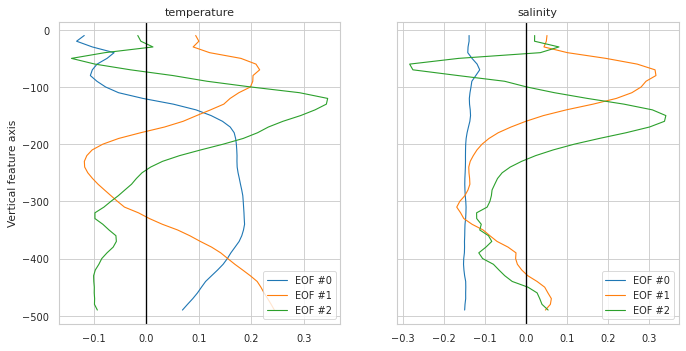

In [335]:
fig, ax = m.plot.reducer()

In [254]:
ds_all['salinity'][-3]

<xarray.DataArray 'salinity' (pressure: 150)>
array([        nan,         nan,         nan,         nan,         nan,
               nan, 30.96261   , 31.4168    , 31.60169   , 31.75797   ,
       31.8964    , 32.00643636, 32.0932    , 32.14591818, 32.22507   ,
       32.2837    , 32.3159    , 32.3601    , 32.40001   , 32.43386364,
       32.45715   , 32.4875    , 32.5195    , 32.5477    , 32.57054545,
       32.5943    , 32.61245   , 32.63992   , 32.65997   , 32.6764    ,
       32.69854   , 32.72978   , 32.76448333, 32.8078    , 32.8562    ,
       32.91408182, 33.008     , 33.0936    , 33.2345    , 33.378     ,
       33.5629    , 33.77274545, 33.9075    , 34.02443   , 34.0767    ,
       34.2084    , 34.29011818, 34.34335   , 34.38464   , 34.41453   ,
       34.44363   , 34.47064545, 34.5004    , 34.52711818, 34.5464    ,
       34.56358   , 34.58602   , 34.60623   , 34.62809   , 34.64267   ,
       34.65401   , 34.67744   , 34.69835455, 34.7151    , 34.7317    ,
       34.7519    , 34.75799091, 34.76715   , 34.7757    , 34.78060909,
       34.781     , 34.7912    , 34.7969    , 34.80179091, 34.8025    ,
       34.803     , 34.8055    , 34.8054    , 34.80559   , 34.8056    ,
       34.8173    , 34.8258    , 34.8285    , 34.83541   , 34.83651   ,
       34.8369    , 34.8366    , 34.8366    , 34.83995   , 34.83961818,
       34.8393    , 34.83910909, 34.8386    , 34.84291   , 34.8447    ,
       34.8505    , 34.8519    , 34.85199   , 34.85216   , 34.85600909,
       34.8558    , 34.85541818, 34.85516   , 34.85523   , 34.85707273,
       34.8572    , 34.8579    , 34.85728   , 34.85681   , 34.8578    ,
       34.8579    , 34.8575    , 34.8569    , 34.85641   , 34.8561    ,
       34.8555    , 34.857     , 34.8582    , 34.85885   , 34.8589    ,
       34.8592    , 34.85919091, 34.85967   , 34.86132   , 34.86081818,
       34.8615    , 34.86149091, 34.86189   , 34.86279   , 34.8623    ,
       34.8626    , 34.86279   , 34.86290909, 34.863     , 34.86357   ,
       34.86389091, 34.8647    , 34.86462   , 34.8647    , 34.86507   ,
       34.8647    , 34.8656    , 34.86539   , 34.8654    , 34.8652    ,
       34.8655    , 34.8656    , 34.8658    , 34.86571   , 34.8661    ])
Coordinates:
    profiler  int64 100
    date      datetime64[ns] 2017-10-17T06:02:02.687999
    lon       float64 -145.5
    lat       float64 79.96
  * pressure  (pressure) float64 10.0 15.0 20.0 25.0 ... 740.0 745.0 750.0 755.0

In [206]:
len(ds_all['lat'].values)

2758

In [51]:
z = np.arange(0.,-1000,-10.)
pcm_features = {'temperature': z, 'salinity':z}

In [53]:
m = pcm(K=8, features=pcm_features,maxvar=3,debug=True)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

In [189]:
import pyxpcm
ds = pyxpcm.tutorial.open_dataset('argo').load()
ds

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 ... -1.395e+03 -1.4e+03 -1.405e+03
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 ...
    LONGITUDE  (N_PROF) float32 ...
    TIME       (N_PROF) datetime64[ns] ...
    DBINDEX    (N_PROF) float64 ...
    TEMP       (N_PROF, DEPTH) float32 ...
    PSAL       (N_PROF, DEPTH) float32 ...
    SIG0       (N_PROF, DEPTH) float32 ...
    BRV2       (N_PROF, DEPTH) float32 ...
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

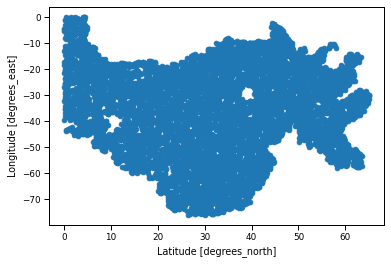

In [55]:
ds.plot.scatter('LATITUDE','LONGITUDE')

In [9]:
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

In [10]:
features_zdim='DEPTH'

In [77]:
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

> Start preprocessing for action 'fit'

	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'
	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in 

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 1.221505

In [42]:
m.predict(ds, features=features_in_ds, inplace=True)
ds

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: PCM_LABELS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


<xarray.Dataset>
Dimensions:           (pcm_class_TEMP_Q: 8, N_PROF: 7560, DEPTH: 282,
                       quantile: 3)
Coordinates:
  * pcm_class_TEMP_Q  (pcm_class_TEMP_Q) int64 0 1 2 3 4 5 6 7
  * N_PROF            (N_PROF) int64 0 1 2 3 4 5 ... 7555 7556 7557 7558 7559
  * DEPTH             (DEPTH) float32 0.0 -5.0 -10.0 ... -1.4e+03 -1.405e+03
  * quantile          (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE          (N_PROF) float32 27.12 27.82 27.45 ... 4.243 4.15 4.44
    LONGITUDE         (N_PROF) float32 -74.86 -75.6 -74.95 ... -0.821 -0.002
    TIME              (N_PROF) datetime64[ns] 2008-06-23T13:07:30 ... 2013-03...
    DBINDEX           (N_PROF) float64 1.484e+04 1.622e+04 ... 1.063e+04
    TEMP              (N_PROF, DEPTH) float32 27.42 27.42 27.29 ... 4.404 4.392
    PSAL              (N_PROF, DEPTH) float32 36.35 36.35 36.47 ... 34.91 34.91
    SIG0              (N_PROF, DEPTH) float32 23.6 23.6 23.73 ... 27.68 27.69
    BRV2              (N_PROF, DEPTH) float32 0.0002945 0.0002945 ... 4.501e-06
    PCM_LABELS        (N_PROF) int64 7 7 7 7 7 7 7 7 7 7 ... 4 4 4 4 4 4 4 4 4 4
    TEMP_Q            (pcm_class_TEMP_Q, quantile, DEPTH) float64 19.14 ... 5...
    PSAL_Q            (pcm_class_TEMP_Q, quantile, DEPTH) float64 36.14 ... 3...
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

In [43]:
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)
ds

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: TEMP_Q variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: PSAL_Q variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


<xarray.Dataset>
Dimensions:           (pcm_class_TEMP_Q: 8, N_PROF: 7560, DEPTH: 282,
                       quantile: 3)
Coordinates:
  * pcm_class_TEMP_Q  (pcm_class_TEMP_Q) int64 0 1 2 3 4 5 6 7
  * N_PROF            (N_PROF) int64 0 1 2 3 4 5 ... 7555 7556 7557 7558 7559
  * DEPTH             (DEPTH) float32 0.0 -5.0 -10.0 ... -1.4e+03 -1.405e+03
  * quantile          (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE          (N_PROF) float32 27.12 27.82 27.45 ... 4.243 4.15 4.44
    LONGITUDE         (N_PROF) float32 -74.86 -75.6 -74.95 ... -0.821 -0.002
    TIME              (N_PROF) datetime64[ns] 2008-06-23T13:07:30 ... 2013-03...
    DBINDEX           (N_PROF) float64 1.484e+04 1.622e+04 ... 1.063e+04
    TEMP              (N_PROF, DEPTH) float32 27.42 27.42 27.29 ... 4.404 4.392
    PSAL              (N_PROF, DEPTH) float32 36.35 36.35 36.47 ... 34.91 34.91
    SIG0              (N_PROF, DEPTH) float32 23.6 23.6 23.73 ... 27.68 27.69
    BRV2              (N_PROF, DEPTH) float32 0.0002945 0.0002945 ... 4.501e-06
    PCM_LABELS        (N_PROF) int64 7 7 7 7 7 7 7 7 7 7 ... 4 4 4 4 4 4 4 4 4 4
    TEMP_Q            (pcm_class_TEMP_Q, quantile, DEPTH) float64 18.59 ... 5...
    PSAL_Q            (pcm_class_TEMP_Q, quantile, DEPTH) float64 36.52 ... 3...
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source DOI:          10.17882/42182

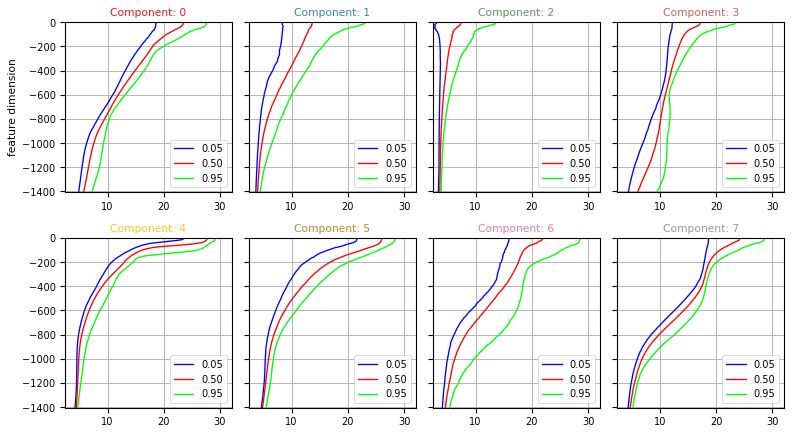

In [44]:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


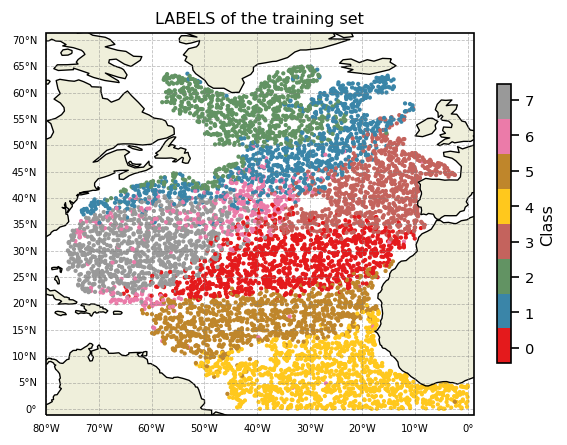

In [45]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

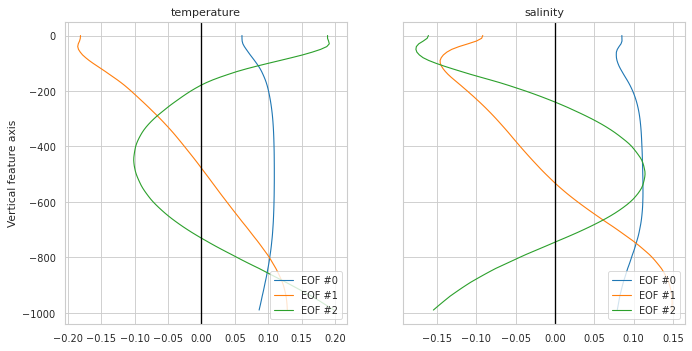

In [46]:
fig, ax = m.plot.reducer()

In [75]:
pcm?

Init signature:
pcm(
    K: int,
    features: {},
    scaling=1,
    reduction=1,
    maxvar=15,
    classif='gmm',
    covariance_type='full',
    verb=False,
    debug=False,
    timeit=False,
    timeit_verb=False,
    chunk_size='auto',
    backend='sklearn',
)
Docstring:     
Profile Classification Model class constructor

Consume and return :mod:`xarray` objects
Init docstring:
Create the PCM instance

Parameters
----------
K: int
    The number of class, or cluster, in the classification model.

features: dict()
    The vertical axis to use for each features.
    eg: {'temperature':np.arange(-2000,0,1)}

scaling: int (default: 1)
    Define the scaling method:

    - 0: No scaling
    - **1: Center on sample mean and scale by sample std**
    - 2: Center on sample mean only

reduction: int (default: 1)
    Define the dimensionality reduction method:

    - 0: No reduction
    - **1: Reduction using :class:`sklearn.decomposition.PCA`**

maxvar: float (default: 99.9)
    Maximum 

In [71]:
import glob
files = glob.glob('scienceweb.whoi.edu/itp/data/*.dat')
len(files)

21682

In [104]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 10911, pressure: 159)
Coordinates:
    profiler     (nprof) int64 103 105 105 104 104 104 ... 104 108 104 103 102
    date         (nprof) datetime64[ns] 2019-06-04T18:02:32.928000 ... 2020-0...
    lon          (nprof) float64 -127.6 -139.3 -129.8 ... -130.2 -130.0 102.5
    lat          (nprof) float64 78.14 79.81 81.33 81.76 ... 80.9 76.98 87.67
  * pressure     (pressure) float64 5.0 10.0 15.0 20.0 ... 785.0 790.0 795.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 nan -1.56 -1.56 -1.57 ... nan nan nan
    salinity     (nprof, pressure) float64 nan 29.85 29.86 29.93 ... nan nan nan

In [122]:
ds_all['profiler']

<xarray.DataArray 'profiler' (nprof: 10911)>
array([103, 105, 105, ..., 104, 103, 102])
Coordinates:
    profiler  (nprof) int64 103 105 105 104 104 104 ... 103 104 108 104 103 102
    date      (nprof) datetime64[ns] 2019-06-04T18:02:32.928000 ... 2020-01-1...
    lon       (nprof) float64 -127.6 -139.3 -129.8 ... -130.2 -130.0 102.5
    lat       (nprof) float64 78.14 79.81 81.33 81.76 ... 76.79 80.9 76.98 87.67
Dimensions without coordinates: nprof

In [257]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 2339, pressure: 150)
Coordinates:
    profiler     (nprof) int64 105 108 10 104 103 107 ... 105 104 100 108 108
    date         (nprof) datetime64[ns] 2019-04-09T00:02:26.016000 ... 2018-0...
    lon          (nprof) float64 -129.8 -141.6 -112.0 ... -145.5 -140.5 -143.7
    lat          (nprof) float64 81.33 78.27 83.43 81.37 ... 79.96 75.71 76.79
  * pressure     (pressure) float64 10.0 15.0 20.0 25.0 ... 745.0 750.0 755.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.665 -1.665 ... 0.4345 0.4304
    salinity     (nprof, pressure) float64 30.44 30.44 30.44 ... 34.86 34.86

In [184]:
ds_all['temperature'][5]

<xarray.DataArray 'temperature' (pressure: 150)>
array([-1.4884    , -1.4883    , -1.4884    , -1.4885    , -1.4883    ,
       -1.4882    , -1.4878    , -1.4882    , -1.24142727, -0.9447    ,
       -0.96820909, -0.9099    , -0.614     , -0.3964    , -0.3118    ,
       -0.36030909, -0.42660909, -0.5102    , -0.55424545, -0.5962    ,
       -0.71377273, -0.79347273, -0.9121    , -1.0341    , -1.1343    ,
       -1.15882727, -1.21988182, -1.2387    , -1.27758182, -1.3043    ,
       -1.3248    , -1.36952727, -1.38836364, -1.4058    , -1.4159    ,
       -1.42278182, -1.435     , -1.4441    , -1.45536364, -1.4643    ,
       -1.46228182, -1.46086364, -1.4409    , -1.416     , -1.3831    ,
       -1.34777273, -1.29172727, -1.23597273, -1.1484    , -1.0603    ,
       -0.9316    , -0.8952    , -0.7612    , -0.64012727, -0.53236364,
       -0.46005455, -0.43328182, -0.34448182, -0.28343636, -0.22181   ,
       -0.14801818, -0.0881    , -0.032     ,  0.0262    ,  0.0875    ,
        0.13757273,  0.1773    ,  0.22518182,  0.2613    ,  0.30248182,
        0.3434    ,  0.3818    ,  0.40862727,  0.43546364,  0.45825455,
        0.47701818,  0.51805455,  0.54160909,  0.55949091,  0.5711    ,
        0.58387273,  0.59404   ,  0.6051    ,  0.6156    ,  0.6254    ,
        0.6334    ,  0.64484545,  0.65856   ,  0.6679    ,  0.68589091,
        0.69272727,  0.6985    ,  0.6987    ,  0.69812727,  0.70499091,
        0.7147    ,  0.7225    ,  0.7251    ,  0.72530909,  0.7223    ,
        0.71749   ,  0.7108    ,  0.7035    ,  0.6914    ,  0.6801    ,
        0.679     ,  0.6809    ,  0.67700909,  0.66951818,  0.6612    ,
        0.66426364,  0.65829   ,  0.647     ,  0.6358    ,  0.62572   ,
        0.61163   ,  0.6031    ,  0.5949    ,  0.58626364,  0.58011   ,
        0.57456   ,  0.56628182,  0.5547    ,  0.5441    ,  0.5343    ,
        0.5247    ,  0.51926   ,  0.51219   ,  0.50595   ,  0.49851   ,
        0.49241   ,  0.48714   ,  0.47931   ,  0.47311   ,  0.4671    ,
        0.46109091,  0.4566    ,  0.45154   ,  0.44535   ,  0.4388    ,
        0.43208   ,  0.42511   ,  0.4178    ,  0.41056   ,  0.40408889,
        0.39949   ,  0.3941    ,  0.388     ,  0.37884   ,  0.37223333])
Coordinates:
    profiler  int64 107
    date      datetime64[ns] 2018-12-29T00:02:05.279999
    lon       float64 -144.3
    lat       float64 73.33
  * pressure  (pressure) float64 10.0 15.0 20.0 25.0 ... 740.0 745.0 750.0 755.0
Attributes:
    units:    C

In [72]:
plevels=np.arange(5,800.,5.)

In [ ]:
# the data filter
import glob
files = glob.glob('scienceweb.whoi.edu/itp/data/*.dat')
len(files)

plevels=np.arange(5,800.,5.)

ds_all=[]
for file in files:
    infile=open(file)
    metadata_names=infile.readline()
    metadata_vals=infile.readline().split()
    infile.close()
    if metadata_vals[-1].isnumeric(): 
        if int(metadata_vals[-1])>1:
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try: 
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                continue
                print('wrong title, dropping'+metadata_names.split(':')[0])
                
            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                         'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                          'lon':float(metadata_vals[2]),
                          'lat':float(metadata_vals[3])}
                         )
            ds=ds.drop_duplicates('pressure',keep='last') 
            if 'dissolved_oxygen' in ds:
                ds=ds.drop('dissolved_oxygen')
            if ds.pressure.size>1:
                ds_all.append(ds.interp({'pressure':plevels},assume_sorted=True)) # interpolate the pressure levels
            else:
                print('Only 1 pressure level, dropping: '+metadata_names.split(':')[0])
        else:
            print('Only 1 measurement, dropping: '+metadata_names.split(':')[0])
    else:
        print('Wrong data fomart, dropping: '+metadata_names.split(':')[0])
    
    #break
    
ds_all=xr.concat(ds_all,'nprof')
ds_all.pressure.attrs['units']='dbar'
ds_all.temperature.attrs['units']='C'

In [258]:
ds_all['temperature'].isel(nprof=10)

<xarray.DataArray 'temperature' (pressure: 150)>
array([-1.6081    , -1.6077    , -1.6076    , -1.51489091, -1.1549    ,
       -1.1592    , -1.1883    , -1.25443636, -1.4815    , -1.5       ,
       -1.55012727, -1.57682727, -1.56025455, -1.52675455, -1.4891    ,
       -1.4695    , -1.4638    , -1.38949091, -1.41568182, -1.46935455,
       -1.51139091, -1.5265    , -1.54318182, -1.55774545, -1.5655    ,
       -1.56698182, -1.54997273, -1.4656    , -1.3929    , -1.34501818,
       -1.28973636, -1.2068    , -1.1338    , -1.07147273, -1.012     ,
       -0.9235    , -0.8501    , -0.73881818, -0.6285    , -0.5465    ,
       -0.4698    , -0.404     , -0.3241    , -0.26646364, -0.18728182,
       -0.0677    , -0.0322    ,  0.03161   ,  0.10208182,  0.1696    ,
        0.2224    ,  0.22532727,  0.30627   ,  0.3798    ,  0.4104    ,
        0.4488    ,  0.49927273,  0.5295    ,  0.57973636,  0.6342    ,
        0.6351    ,  0.64307273,  0.6627    ,  0.6815    ,  0.7121    ,
        0.71229   ,  0.7109    ,  0.71036   ,  0.7063    ,  0.71322   ,
        0.7407    ,  0.77329   ,  0.7915    ,  0.82167   ,  0.8223    ,
        0.82260909,  0.8233    ,  0.8235    ,  0.8222    ,  0.8147    ,
        0.8158    ,  0.81592   ,  0.8069    ,  0.79836   ,  0.7851    ,
        0.77481818,  0.77155455,  0.7714    ,  0.78468   ,  0.7888    ,
        0.792     ,  0.78571   ,  0.7865    ,  0.775     ,  0.7602    ,
        0.7483    ,  0.7346    ,  0.72427273,  0.70944   ,  0.6946    ,
        0.6755    ,  0.65564   ,  0.64923   ,  0.64288182,  0.6315    ,
        0.61393636,  0.59707   ,  0.58473   ,  0.57085455,  0.5732    ,
        0.5697    ,  0.5672    ,  0.55547273,  0.5443    ,  0.53830909,
        0.5321    ,  0.52226364,  0.51241   ,  0.50707273,  0.5017    ,
        0.49045455,  0.4822    ,  0.4707    ,  0.4655    ,  0.45493   ,
        0.44655   ,  0.4396    ,  0.43221   ,  0.42469   ,  0.4152    ,
        0.40701   ,  0.39673333,  0.38758   ,  0.3772    ,  0.3673    ,
        0.35859   ,  0.34597   ,  0.3347    ,  0.32612   ,  0.31802   ,
        0.31294   ,  0.30484   ,  0.29998   ,  0.29246   ,  0.28386   ,
        0.26992   ,  0.26536364,  0.2566    ,  0.24856   ,  0.24501   ])
Coordinates:
    profiler  int64 108
    date      datetime64[ns] 2017-09-27T00:02:02.688000
    lon       float64 -135.9
    lat       float64 80.76
  * pressure  (pressure) float64 10.0 15.0 20.0 25.0 ... 740.0 745.0 750.0 755.0
Attributes:
    units:    C

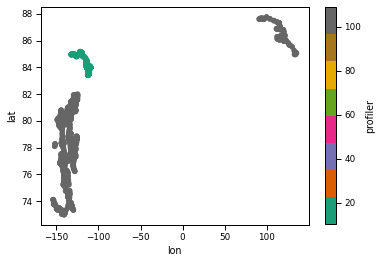

In [259]:
ds_all.plot.scatter('lon','lat',hue='profiler',cmap='Dark2')

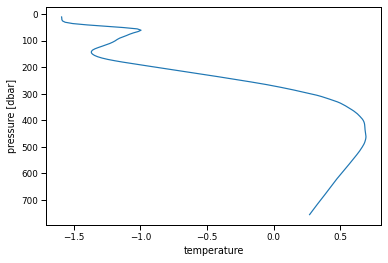

In [260]:
ds_all['temperature'].mean('nprof').plot(y='pressure',yincrease=False)

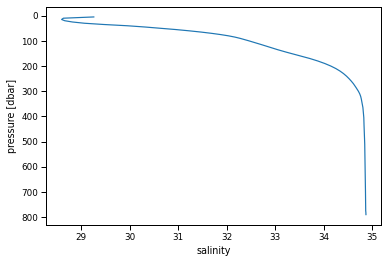

In [242]:
ds_all['salinity'].mean('nprof').plot(y='pressure',yincrease=False)

In [36]:
ds_all['pressure']=-ds_all['pressure']

In [24]:
z = np.arange(-10.,-500,-10.)
pcm_features = {'temperature': z, 'salinity':z}

In [25]:
m = pcm(K=3, features=pcm_features,maxvar=3)

In [28]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 10168, pressure: 159)
Coordinates:
    profiler     (nprof) int64 9 1 6 4 8 2 3 5 5 7 6 ... 3 1 3 7 2 8 8 3 7 6 6
    date         (nprof) datetime64[ns] 2008-03-13T00:24:16.704000 ... 2007-0...
    lon          (nprof) float64 -80.67 -140.6 -139.8 ... -8.939 -149.8 -139.3
    lat          (nprof) float64 85.38 77.95 75.1 79.02 ... 86.92 82.02 76.57
  * pressure     (pressure) float64 5.0 10.0 15.0 20.0 ... 785.0 790.0 795.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 nan -1.645 -1.645 ... nan nan nan
    salinity     (nprof, pressure) float64 nan 30.04 30.05 30.06 ... nan nan nan
    nobs         (nprof, pressure) float64 nan 4.0 4.091 4.0 ... nan nan nan nan

In [49]:
features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}

In [50]:
m.fit(ds_cleaned,features=features_in_ds,dim='pressure')

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -2.392126

In [51]:
ds_cleaned=m.predict(ds_cleaned,features=features_in_ds,dim='pressure',inplace=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: PCM_LABELS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


In [41]:
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 8257, pressure: 99)
Coordinates:
  * nprof        (nprof) int64 0 1 2 3 4 5 6 ... 8251 8252 8253 8254 8255 8256
    profiler     (nprof) int64 9 1 4 8 3 5 7 6 10 6 4 ... 8 9 4 3 1 3 7 8 8 3 7
    date         (nprof) datetime64[ns] 2008-03-13T00:24:16.704000 ... 2007-0...
    lon          (nprof) float64 -80.67 -140.6 -149.0 ... -137.3 -137.0 -8.939
    lat          (nprof) float64 85.38 77.95 79.02 80.66 ... 80.28 77.48 86.92
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Data variables:
    temperature  (nprof, pressure) float64 -1.645 -1.645 ... 0.6835 0.6511
    salinity     (nprof, pressure) float64 30.04 30.05 30.06 ... 34.87 34.87
    nobs         (nprof, pressure) float64 4.0 4.091 4.0 4.0 ... 4.0 4.0 4.0 4.0
    PCM_LABELS   (nprof) int64 2 0 0 0 0 0 1 0 2 0 0 0 ... 0 2 0 0 0 0 1 0 0 0 1

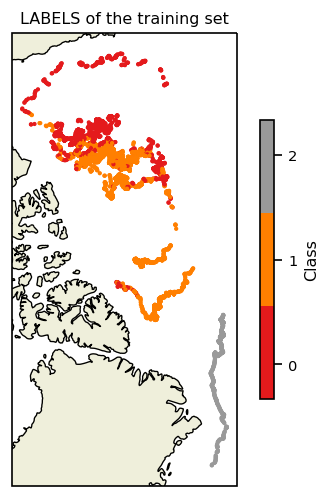

In [52]:
proj = ccrs.NorthPolarStereo()
subplot_kw={'projection': proj, 
            #'extent':([-180,180,60,90],ccrs.PlateCarree())
           }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds_cleaned['lon'], ds_cleaned['lat'], s=3, c=ds_cleaned['PCM_LABELS'], cmap=kmap, transform=ccrs.PlateCarree(), vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

#gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

In [304]:
for vname in ['temperature', 'salinity']:
    ds_cleaned = ds_cleaned.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)
ds_cleaned

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: temperature_Q variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/xarray.py:89: UserWarning: salinity_Q variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


<xarray.Dataset>
Dimensions:                  (pcm_class_temperature_Q: 3, nprof: 10168,
                              pressure: 99, quantile: 3)
Coordinates:
  * pcm_class_temperature_Q  (pcm_class_temperature_Q) int64 0 1 2
  * nprof                    (nprof) int64 0 1 2 3 4 ... 10164 10165 10166 10167
    profiler                 (nprof) int64 9 1 6 4 8 2 3 5 5 ... 7 2 8 8 3 7 6 6
    date                     (nprof) datetime64[ns] 2008-03-13T00:24:16.70400...
    lon                      (nprof) float64 -80.67 -140.6 ... -149.8 -139.3
    lat                      (nprof) float64 85.38 77.95 75.1 ... 82.02 76.57
  * pressure                 (pressure) float64 -10.0 -15.0 ... -495.0 -500.0
  * quantile                 (quantile) float64 0.05 0.5 0.95
Data variables:
    temperature              (nprof, pressure) float64 -1.645 -1.645 ... 0.6533
    salinity                 (nprof, pressure) float64 30.04 30.05 ... 34.84
    nobs                     (nprof, pressure) float64 4.0 4.091 4.0 ... 4.0 4.0
    PCM_LABELS               (nprof) float64 1.0 1.0 nan 1.0 ... 1.0 2.0 nan nan
    temperature_Q            (pcm_class_temperature_Q, quantile, pressure) float64 ...
    salinity_Q               (pcm_class_temperature_Q, quantile, pressure) float64 ...

In [310]:
fig, ax = m.plot.quantile(ds_cleaned['temperature_Q'],classdimname='PCM_LABELS',quantdimname='quantile', maxcols=4, figsize=(10, 8), sharey=True)

ValueError: Can't distinguish the class dimension from the others

In [307]:
m.plot.quantile?

Signature: m.plot.quantile(da, **kwargs)
Docstring:
Plot q-th quantiles of a dataArray for each PCM components

Parameters
----------
m : :class:`pyxpcm.pcm` instance

da: :class:`xarray.DataArray` with quantiles

xlim

classdimname

quantdimname

maxcols

Returns
-------
fig : :class:`matplotlib.pyplot.figure.Figure`

ax : :class:`matplotlib.axes.Axes` object or array of Axes objects.
    *ax* can be either a single :class:`matplotlib.axes.Axes` object or an
    array of Axes objects if more than one subplot was created.  The
    dimensions of the resulting array can be controlled with the squeeze
    keyword.
File:      /srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/plot.py
Type:      method


In [38]:
ds_cleaned=ds_all.sel(pressure=slice(-10,-500)).dropna('nprof')
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 8257, pressure: 99)
Coordinates:
    profiler     (nprof) int64 9 1 4 8 3 5 7 6 10 6 4 ... 8 9 4 3 1 3 7 8 8 3 7
    date         (nprof) datetime64[ns] 2008-03-13T00:24:16.704000 ... 2007-0...
    lon          (nprof) float64 -80.67 -140.6 -149.0 ... -137.3 -137.0 -8.939
    lat          (nprof) float64 85.38 77.95 79.02 80.66 ... 80.28 77.48 86.92
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.645 -1.645 ... 0.6835 0.6511
    salinity     (nprof, pressure) float64 30.04 30.05 30.06 ... 34.87 34.87
    nobs         (nprof, pressure) float64 4.0 4.091 4.0 4.0 ... 4.0 4.0 4.0 4.0

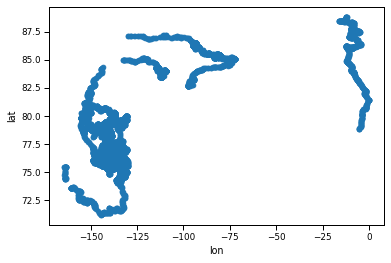

In [30]:
ds_cleaned.dropna('nprof').plot.scatter('lon','lat')

In [48]:
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 8257, pressure: 99)
Coordinates:
  * nprof        (nprof) int64 0 1 2 3 4 5 6 ... 8251 8252 8253 8254 8255 8256
    profiler     (nprof) int64 9 1 4 8 3 5 7 6 10 6 4 ... 8 9 4 3 1 3 7 8 8 3 7
    date         (nprof) datetime64[ns] 2008-03-13T00:24:16.704000 ... 2007-0...
    lon          (nprof) float64 -80.67 -140.6 -149.0 ... -137.3 -137.0 -8.939
    lat          (nprof) float64 85.38 77.95 79.02 80.66 ... 80.28 77.48 86.92
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Data variables:
    temperature  (nprof, pressure) float64 -1.645 -1.645 ... 0.6835 0.6511
    salinity     (nprof, pressure) float64 30.04 30.05 30.06 ... 34.87 34.87
    nobs         (nprof, pressure) float64 4.0 4.091 4.0 4.0 ... 4.0 4.0 4.0 4.0
    PCM_LABELS   (nprof) int64 2 0 0 0 0 0 1 0 2 0 0 0 ... 0 2 0 0 0 0 1 0 0 0 1

In [53]:
m.bic(ds_cleaned,features=features_in_ds,dim='pressure')

PCMFeatureError: You must specify a vertical dimension name: use argument 'dim' or specify DataSet dimension the attribute 'axis' to 'Z' (CF1.6)

In [54]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33761")
client

<Client: 'tcp://127.0.0.1:33761' processes=6 threads=6, memory=48.00 GiB>

2023-04-03 14:02:17,191 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [47]:
m.bic?

Signature: m.bic(ds, features=None, dim=None)
Docstring:
Compute Bayesian information criterion for the current model on the input dataset

Only for a GMM classifier

Parameters
----------
ds: :class:`xarray.Dataset`
    The dataset to work with

features: dict()
    Definitions of PCM features in the input :class:`xarray.Dataset`.
    If not specified or set to None, features are identified using :class:`xarray.DataArray` attributes 'feature_name'.

dim: str
    Name of the vertical dimension in the input :class:`xarray.Dataset`

Returns
-------
bic: float
    The lower the better
File:      /srv/conda/envs/notebook/lib/python3.9/site-packages/pyxpcm/models.py
Type:      method
